# infrastructure-attributes

The procedure of constructing infrastructure attributes for supernodes.

Requires:
1. `data/preprocessed/infrastructure.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/supernode_attributes.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import chain, product

import numpy as np
import pandas as pd
import seaborn as sns
from cartopy import crs as ccrs
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from config import infrastructure_fpath, supernodes_fpath, supernode_attributes_fpath
from cartopy_config import vaska_area, get_supernode_props
from ptn.cartopy import add_map_subplot

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [4]:
infrastructure = pd.read_json(infrastructure_fpath)

infrastructure.head(2)

,id,lat,lon,types,name,diameter
0,267959524,59.661098,30.785173,[Tourism],Саблинский водопад,0.0
1,268911313,59.688758,29.920383,[Car service],Киришиавтосервис 13,0.0


In [5]:
infrastructure_type_counts = pd.Series(chain.from_iterable(infrastructure['types'])).value_counts()

infrastructure_types = infrastructure_type_counts.index.tolist()

infrastructure_type_counts.head()

Housing       30946
Shopping      15925
Restaurant     8335
Services       4634
Medicine       4454
dtype: int64

In [6]:
infrastructure_coords = infrastructure[['lat', 'lon']].values
supernode_coords = supernodes[['lat', 'lon']].values

supernode_diameters = supernodes['diameter'].values

In [7]:
window = 0.2

In [8]:
supernode_attributes = pd.DataFrame(index=supernodes.index, columns=infrastructure_types).fillna(0)

dmins = []

for i, coords in enumerate(tqdm(infrastructure_coords)):
    obj = infrastructure.iloc[i]
    obj_types = obj['types']
    obj_diameter = obj['diameter']
    
    distances = get_earth_distances(coords.reshape(1, -1), supernode_coords).flatten()\
        - supernode_diameters / 2 - obj_diameter / 2
    distances[distances < 0] = 0
    
    dmin = distances.min()
    dmins.append(dmin)
    
    if dmin >= 1:
        continue
    
    dmax = dmin + window

    close_supernodes = supernodes.index[np.where(distances <= dmax)[0]]
    
    for s, t in product(close_supernodes, obj_types):
        supernode_attributes.loc[s, t] += 1
        
dmins = np.array(dmins)
        
supernode_attributes = supernode_attributes.reset_index()

supernode_attributes.head(2)

100%|███████████████████████████████████████████████████████████████████████████| 89563/89563 [01:13<00:00, 1214.56it/s]


,id,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,...,Administrative,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre
0,0,141,149,74,43,46,21,14,33,5,...,8,13,3,2,27,13,4,0,0,0
1,1,111,114,108,42,51,33,41,13,6,...,18,6,13,6,7,9,4,7,1,0


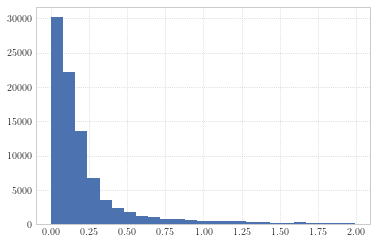

In [9]:
plt.hist(dmins, bins=25);

In [10]:
supernode_attributes_json = [row.to_dict() for _, row in supernode_attributes.iterrows()]

len(supernode_attributes_json)

3202

In [11]:
save_json(supernode_attributes_json, supernode_attributes_fpath)

***

In [8]:
infrastructure_colors = {
    t: f'C{i}' if i < 3 else f'C{i + 1}'
    for i, t in enumerate(infrastructure_type_counts.index[:5])
}
infrastructure_colors

{'Housing': 'C0',
 'Shopping': 'C1',
 'Restaurant': 'C2',
 'Services': 'C4',
 'Medicine': 'C5'}

In [15]:
infrastructure_markers = dict(zip(infrastructure_colors, list('so^+x')))

infrastructure_markers

{'Housing': 's',
 'Shopping': 'o',
 'Restaurant': '^',
 'Services': '+',
 'Medicine': 'x'}

100%|████████████████████████████████████████████████████████████████████| 89563/89563 [00:18<00:00, 4821.18it/s]


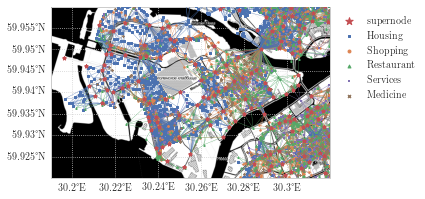

In [16]:
fig = plt.figure(figsize=(5, 4))

extent, scale, factor = vaska_area

ax = add_map_subplot(fig, 1, 1, 1, extent=extent, scale=scale)

color, marker, size, width, linestyle, zorder = get_supernode_props(factor)
zorder += 10
size *= 1.5

ax.scatter(*supernode_coords[:, ::-1].T, transform=ccrs.PlateCarree(),
           color=color, marker=marker, s=size, zorder=zorder, label='supernode')

infr_size = size / 7

for i, infr_type in enumerate(infrastructure_types):
    mask = infrastructure['types'].apply(lambda t: t[0] == infr_type).values
    
    if infr_type not in infrastructure_colors:
        continue
    
    color = infrastructure_colors[infr_type]
    marker = infrastructure_markers[infr_type]

    if i < len(infrastructure_colors):
        label = infr_type
    elif i == len(infrastructure_colors):
        label = 'other'
    else:
        label = None
        
    s = infr_size if color != 'k' else s / 3
    
    ax.scatter(*infrastructure_coords[mask, ::-1].T, transform=ccrs.PlateCarree(),
               color=color, marker=marker, s=s, zorder=zorder - 5 + i, label=label)
    
infr_width = width / 5

for i, coords in enumerate(tqdm(infrastructure_coords)):
    y, x = coords
    
    if x < extent[0] or x > extent[1] or y < extent[2] or y > extent[3]:
        continue
    
    obj = infrastructure.iloc[i]
    obj_type = obj['types'][0]
    
    if obj_type not in infrastructure_colors:
        continue
    
    obj_color = infrastructure_colors[obj_type]
    obj_diameter = obj['diameter']
    obj_marker = infrastructure_markers[obj_type]
    
    distances = get_earth_distances(coords.reshape(1, -1), supernode_coords).flatten()\
        - supernode_diameters / 2 - obj_diameter / 2
    distances[distances < 0] = 0
    
    dmin = distances.min()
    
    if dmin >= 1:
        continue
    
    dmax = dmin + window

    close_supernodes = np.where(distances <= dmax)[0]
    
    for j in close_supernodes:
        x0, y0 = supernodes.iloc[j][['lon', 'lat']]
        ax.plot([x, x0], [y, y0], transform=ccrs.PlateCarree(),
                color=obj_color, zorder=zorder - 6, lw=infr_width)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=2)

plt.savefig('../figures/supernode_attributes_map.jpg', dpi=300, bbox_inches='tight')